# Importando Módulos

In [1]:
import obspy
from obspy import Trace
from obspy.signal.util import next_pow_2
import glidertools as gt
import os
import glob
import numpy as np
from collections import defaultdict
import pandas as pd
from scipy.io import wavfile

#para plotar as figuras
import matplotlib.pyplot as plt
from matplotlib.transforms import offset_copy
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition,inset_axes
import matplotlib.colors as colors
import matplotlib.cm as cm
from matplotlib.dates import YearLocator, MonthLocator, DayLocator, HourLocator, MinuteLocator, SecondLocator, DateFormatter
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import matplotlib.gridspec as gridspec

from datetime import datetime,timedelta,date
from tqdm import tqdm

from shapely.geometry.polygon import LinearRing

import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import obspy
import glidertools as gt
import os
import glob
import numpy as np
from collections import defaultdict
import pandas as pd

#para plotar as figuras
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from matplotlib.transforms import offset_copy
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition,inset_axes
import matplotlib.colors as colors
import matplotlib.cm as cm
from matplotlib.dates import YearLocator, MonthLocator, DayLocator, HourLocator, MinuteLocator, SecondLocator, DateFormatter
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

from datetime import datetime,timedelta,date
from tqdm import tqdm

from shapely.geometry.polygon import LinearRing

import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import cartopy.feature as cfeature


# Inputs e outputs 

In [2]:
FOLDER_OUTPUT = '/home/diogoloc/dados_posdoc/gliders_project/OUTPUT/'

In [3]:
FOLDER_INPUT = '/home/diogoloc/dados_posdoc/gliders_project/gliders_data/conversion_test/'

# Extraindo informações dos dados brutos e reamostrados

In [4]:
# r=root, d=directories, f = files
file_names = []
for r, d, f in os.walk(FOLDER_INPUT):
    for file in f:
        if file.endswith(".wav") or file.endswith(".mseed"):
            file_names.append(os.path.join(r, file))

In [5]:
file_names_mseed = sorted([i.split('/')[-1].split('.mseed')[0] for i in file_names if '.mseed' in i])
file_names_mseed = file_names_mseed[0:1]

In [6]:
file_names_mseed

['pa0008au_001_190904_023421']

In [7]:
for filename in file_names_mseed:
    # Retrieving header informations
    if 'pa' in filename.split('_')[0]:
        mergulho = filename.split('_')[0].split('a')[1]
        stream_number = filename.split('_')[1]

        year_month_day = filename.split('_')[2]
        hour_minute_second = filename.split('_')[3].split('.')[0]

        year = int('20'+year_month_day[:2])
        month = int(year_month_day[2:4])
        day = int(year_month_day[4:])

        hour = int(hour_minute_second[:2])
        minute = int(hour_minute_second[2:4])
        second = int(hour_minute_second[4:])

        d = obspy.UTCDateTime(datetime(year,month,day,hour,minute,second).isoformat())

    if 'pa' in filename.split('_')[2]:

        mergulho = filename.split('_')[2].split('a')[1]
        stream_number = filename.split('_')[3]

        year_month_day = filename.split('_')[0]
        hour_minute_second = filename.split('_')[1].split('.')[0]

        year = int('20'+year_month_day[:2])
        month = int(year_month_day[2:4])
        day = int(year_month_day[4:])

        hour = int(hour_minute_second[:2])
        minute = int(hour_minute_second[2:4])
        second = int(hour_minute_second[4:])

        d = obspy.UTCDateTime(datetime(year,month,day,hour,minute,second).isoformat())
    
    # --------------------------------------------------------------------------
    files_f = [k for k in file_names if filename in k]
    file_raw = [w for w in files_f if 'wav_raw' in w][0]
    file_100_hz_wav = [w for w in files_f if 'Resample_100hz' in w][0]
    file_100_hz_mseed = [w for w in files_f if 'mseed' in w][0]
   
    #wav raw
    sampleratetr, datatr = wavfile.read(file_raw)
    tr = Trace(data=datatr)
    tr.stats.sampling_rate = sampleratetr
    tr.stats.starttime = d 
    tr.detrend('linear')
    tr.detrend('demean')
    tr.taper(type='cosine', max_percentage=0.05)

    #wav 100 Hz
    sampleratetr_100Hz, datatr_100Hz = wavfile.read(file_100_hz_wav)
    tr_100Hz = Trace(data=datatr_100Hz)
    tr_100Hz.stats.sampling_rate = sampleratetr_100Hz
    tr_100Hz.stats.starttime = d 
    tr_100Hz.detrend('linear')
    tr_100Hz.detrend('demean')
    tr_100Hz.taper(type='cosine', max_percentage=0.05)
    
    #mseed 100 Hz
    tr_100_hz_mseed = obspy.read(file_100_hz_mseed)[0]
    tr_100_hz_mseed.detrend('linear')
    tr_100_hz_mseed.detrend('demean')
    tr_100_hz_mseed.taper(type='cosine', max_percentage=0.05)
    

    dat = [tr,tr_100Hz,tr_100_hz_mseed]

/tmp/ipykernel_314754/898752719.py:45: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sampleratetr, datatr = wavfile.read(file_raw)
/tmp/ipykernel_314754/898752719.py:54: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sampleratetr_100Hz, datatr_100Hz = wavfile.read(file_100_hz_wav)


In [10]:
dat[0].stats

         network: 
         station: 
        location: 
         channel: 
       starttime: 2019-09-04T02:34:21.000000Z
         endtime: 2019-09-04T02:44:20.999992Z
   sampling_rate: 128000.0
           delta: 7.8125e-06
            npts: 76800000
           calib: 1.0
      processing: ["ObsPy 1.4.0: detrend(options={}::type='linear')", "ObsPy 1.4.0: detrend(options={}::type='demean')", "ObsPy 1.4.0: taper(max_length=None::max_percentage=0.05::side='both'::type='cosine')"]

In [11]:
dat[0].stats.starttime

2019-09-04T02:34:21.000000Z

In [18]:
round(abs((dat[0].stats.starttime - dat[0].stats.endtime)/60),2)

10.0

In [ ]:
dat[0].stats.sampling_rate

In [ ]:
dat[0].stats.npts

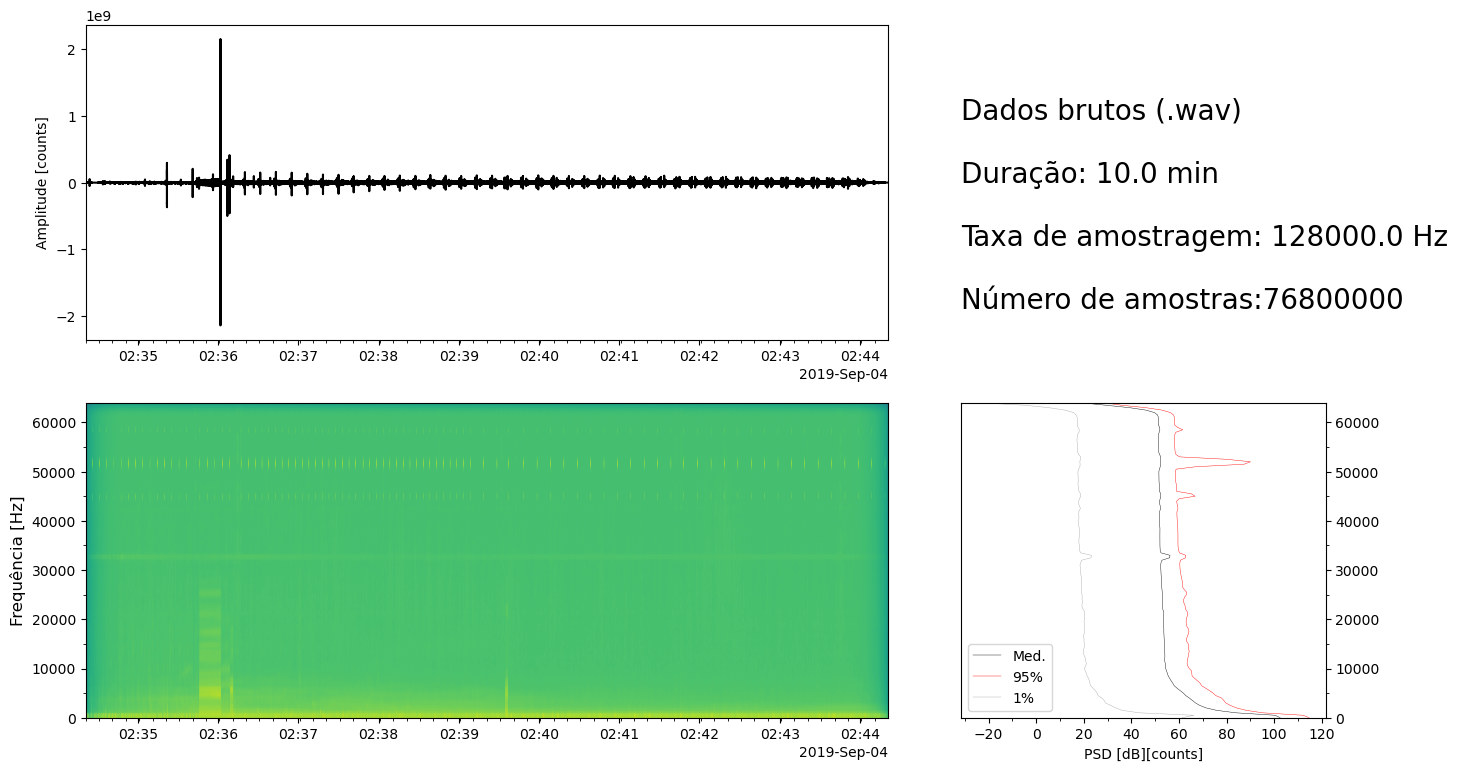

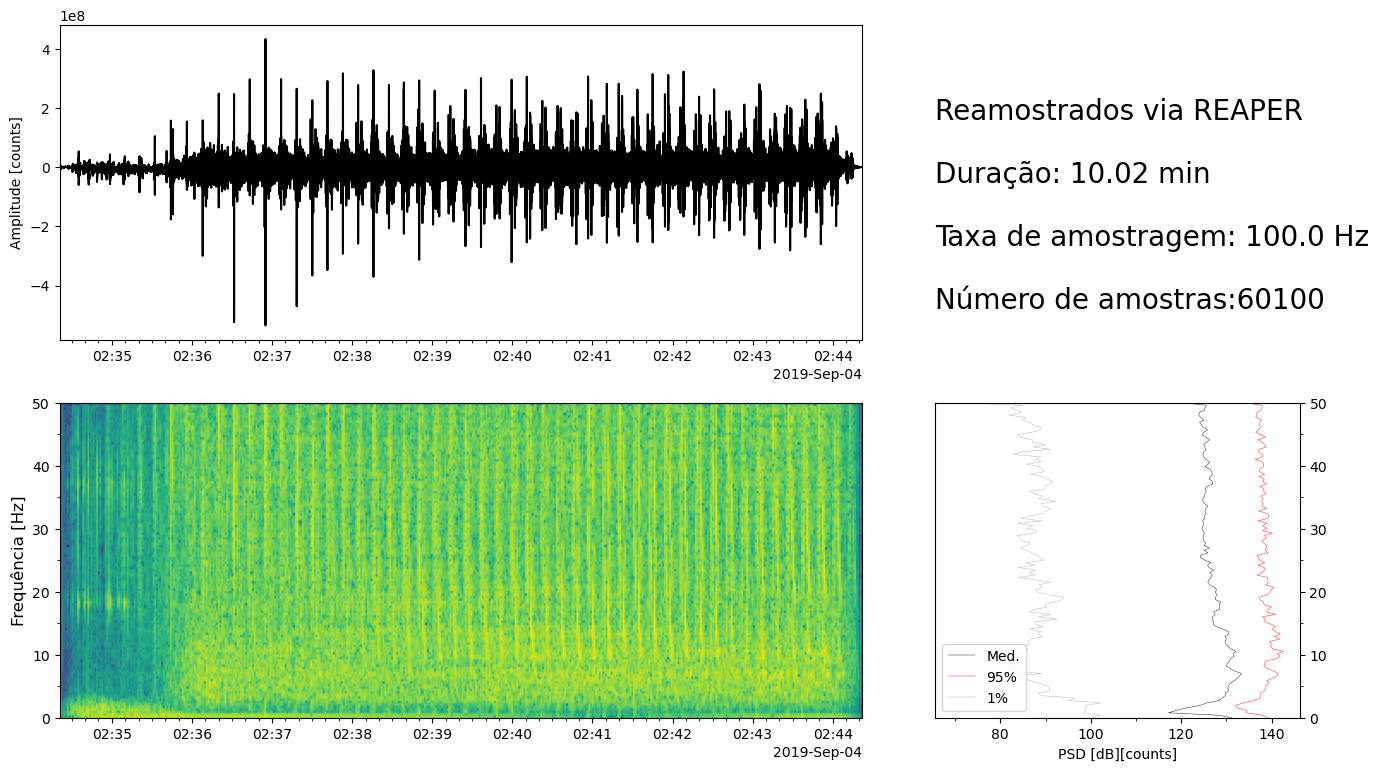

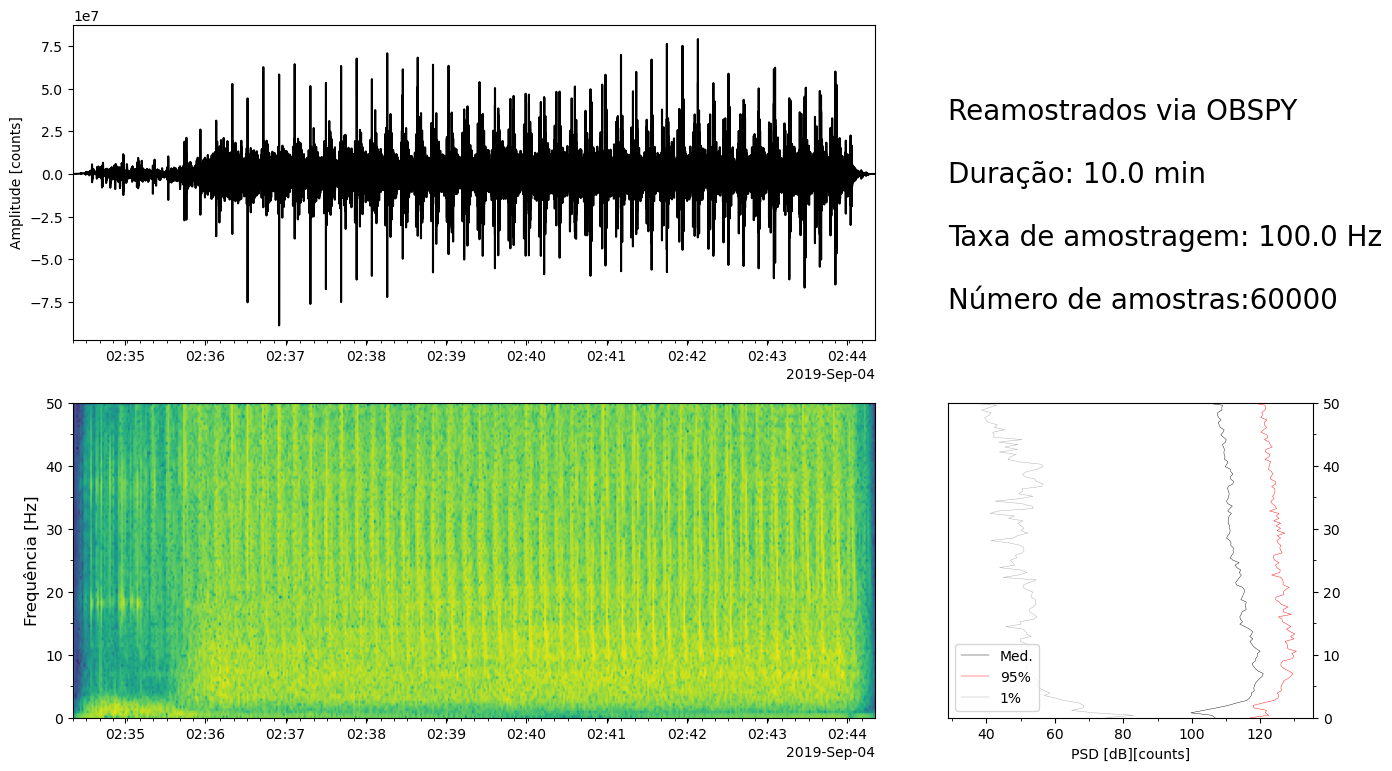

In [22]:
files_f_label = ['Dados brutos (.wav)','Reamostrados via REAPER','Reamostrados via OBSPY']

for i in range(3):
    fig = plt.figure(figsize=(16,9))

    gs0 = gridspec.GridSpec(2, 3, figure=fig)

    ax1 = fig.add_subplot(gs0[0, 0:2])
    ax2 = fig.add_subplot(gs0[1, 0:2],sharex=ax1)
    ax3 = fig.add_subplot(gs0[0, 2])
    ax4 = fig.add_subplot(gs0[1, 2],sharey=ax2)

    winlen = int(4 * dat[i].stats.sampling_rate)
    ax1.plot(dat[i].times('matplotlib'),dat[i].data,'-k')
    ax1.set_ylabel('Amplitude [counts]')
    # -----------------------------------------------------------------------------------------

    powerSpectrum, frequenciesFound, time, imageAxis = ax2.specgram(dat[i].data, Fs=dat[i].stats.sampling_rate,xextent=(dat[i].times('matplotlib')[0],dat[i].times('matplotlib')[-1]))
    ax2.set_ylabel('Frequência [Hz]', fontsize=12,va='bottom')
    
    locator = mdates.AutoDateLocator(minticks=9, maxticks=14)
    formatter = mdates.ConciseDateFormatter(locator)
    ax2.xaxis.set_major_locator(locator)
    ax2.xaxis.set_major_formatter(formatter)
    mins2 = MinuteLocator(interval=1)
    mins1 = SecondLocator(interval=10)
    ax2.xaxis.set_major_locator(mins2)
    ax2.xaxis.set_minor_locator(mins1)

    # -----------------------------------------------------------------------------------------
    ax3.text(0,0.7,files_f_label[i],fontsize=20)
    ax3.text(0,0.5,'Duração: '+str(round(abs((dat[i].stats.starttime - dat[i].stats.endtime)/60),2))+' min',fontsize=20)
    ax3.text(0,0.3,'Taxa de amostragem: '+str(dat[i].stats.sampling_rate)+' Hz',fontsize=20)
    ax3.text(0,0.1,'Número de amostras:'+str(dat[i].stats.npts),fontsize=20)
    ax3.axis('off')
    
    # -----------------------------------------------------------------------------------------
    
    t = np.array([obspy.UTCDateTime(k + dat[i].stats.starttime.timestamp) for k in time])
    median = np.percentile(powerSpectrum, axis=1, q=50)
    perc_95 = np.percentile(powerSpectrum, axis=1, q=95)
    perc_01 = np.percentile(powerSpectrum, axis=1, q=1)

    ax4.plot(10 * np.log10(median),frequenciesFound,color='k',lw=0.3,label='Med.')
    ax4.plot(10 * np.log10(perc_95),frequenciesFound,color='r',lw=0.3,label='95%')
    ax4.plot(10 * np.log10(perc_01),frequenciesFound,color='darkgrey',lw=0.3,label='1%')

    ax4.set_xlabel('PSD [dB][counts]')
    ax4.yaxis.set_label_position("right")
    ax4.yaxis.set_ticks_position("right")
    ax4.yaxis.set_major_locator(MultipleLocator(10))
    ax4.yaxis.set_minor_locator(MultipleLocator(5))
    ax4.xaxis.set_major_locator(MultipleLocator(20))
    ax4.xaxis.set_minor_locator(MultipleLocator(10))
    ax4.legend(loc='lower left')
    
    if i == 0:
        ax4.yaxis.set_major_locator(MultipleLocator(10000))
        ax4.yaxis.set_minor_locator(MultipleLocator(5000))